# 小觅相机标定

In [1]:
import cv2

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
 
import sys
import numpy as np
import glob
class shuangmu:
    def __init__(self):
        self.m1 = 0
        self.m2 = 0
        self.d1 = 0
        self.d2 = 0
        self.R = 0
        self.T = 0
stereo = shuangmu()

class StereoCalibration(object):
    def __init__(self):
        self.imagesL = self.read_images('imagenew/camL')
        self.imagesR = self.read_images('imagenew/camR')
        
    def read_images(self , cal_path):
        filepath = glob.glob(cal_path + '/*.jpg')
        filepath.sort()
        self.filenum = len(filepath)
        return filepath
    
    #标定图像
    def calibration_photo(self):
        #设置要标定的角点个数
        x_nums = 7                                                   #x方向上的角点个数
        y_nums = 5
        # 设置(生成)标定图在世界坐标中的坐标
        world_point = np.zeros((x_nums * y_nums,3),np.float32)            #生成x_nums*y_nums个坐标，每个坐标包含x,y,z三个元素
        world_point[:,:2] = np.mgrid[:x_nums,:y_nums].T.reshape(-1, 2)    #mgrid[]生成包含两个二维矩阵的矩阵，每个矩阵都有x_nums列,y_nums行
                                                                            #.T矩阵的转置
                                                                            #reshape()重新规划矩阵，但不改变矩阵元素
        #保存角点坐标
        world_position = []
        image_positionl = []
        image_positionr = []
        #设置角点查找限制
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,30,0.001)
        #获取所有标定图
        for ii in range(self.filenum):

            image_path_l = self.imagesL[ii]
            image_path_r = self.imagesR[ii]

            image_l = cv2.imread(image_path_l)
            image_r = cv2.imread(image_path_r)
            gray_l = cv2.cvtColor(image_l,cv2.COLOR_RGB2GRAY)
            gray_r = cv2.cvtColor(image_r,cv2.COLOR_RGB2GRAY)
#             print(image_path_l)

            #查找角点
    #         ok,corners = cv2.findChessboardCorners(gray,(x_nums,y_nums),None)
            ok1,cornersl = cv2.findChessboardCorners(gray_l,(x_nums,y_nums),None)
            ok2,cornersr = cv2.findChessboardCorners(gray_r,(x_nums,y_nums),None)
#             ok1,cornersl = cv2.findCirclesGrid(gray_l,(x_nums,y_nums),None)
#             ok2,cornersr = cv2.findCirclesGrid(gray_r,(x_nums,y_nums),None)
            
            self.world = world_point
#             print(ok1&ok2)
            if ok1&ok2:
                #把每一幅图像的世界坐标放到world_position中
                center_spacing = 21.5     ## 圆心的位置距离，这一个其实不重要
                world_position.append(world_point*center_spacing)
                #获取更精确的角点位置
                exact_cornersl = cv2.cornerSubPix(gray_l,cornersl,(11,11),(-1,-1),criteria)
                exact_cornersr = cv2.cornerSubPix(gray_r,cornersr,(11,11),(-1,-1),criteria)
                #把获取的角点坐标放到image_position中
                image_positionl.append(exact_cornersl)
                image_positionr.append(exact_cornersr)
                #可视化角点
    #             image = cv2.drawChessboardCorners(image,(x_nums,y_nums),exact_corners,ok)
    #             cv2.imshow('image_corner',image)
    #             cv2.waitKey(0)
        #计算内参数
        image_shape = gray_l.shape[::-1]
        
        retl, mtxl, distl, rvecsl, tvecsl = cv2.calibrateCamera(world_position, image_positionl, image_shape , None,None)
        retr, mtxr, distr, rvecsr, tvecsr = cv2.calibrateCamera(world_position, image_positionr, image_shape , None,None)
        print('ml = ',mtxl)
        print('mr = ',mtxr)
        print('dl = ' , distl)
        print('dr = ' , distr)
        stereo.m1 = mtxl
        stereo.m2 = mtxr
        stereo.d1 = distl
        stereo.d2 = distr
        
        
        #计算误差
        self.cal_error(world_position , image_positionl ,  mtxl , distl , rvecsl , tvecsl)
        self.cal_error(world_position , image_positionr ,  mtxr,  distr , rvecsr , tvecsr)

        ##双目标定
        self.stereo_calibrate( world_position ,image_positionl , image_positionr , mtxl, distl, mtxr, distr, image_shape)
        
    def cal_error(self , world_position , image_position ,  mtx , dist , rvecs , tvecs):
        #计算偏差
        mean_error = 0
        for i in range(len(world_position)):
            image_position2, _ = cv2.projectPoints(world_position[i], rvecs[i], tvecs[i], mtx, dist)
            error = cv2.norm(image_position[i], image_position2, cv2.NORM_L2) / len(image_position2)
            mean_error += error
        print("total error: ", mean_error / len(image_position))

    def stereo_calibrate( self ,  objpoints ,imgpoints_l , imgpoints_r , M1, d1, M2, d2, dims):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +cv2.TERM_CRITERIA_EPS, 100, 1e-5)
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
                                    objpoints, imgpoints_l,
                                    imgpoints_r, M1, d1, M2,
                                    d2, dims,
                                    criteria=stereocalib_criteria, flags=flags)
        print(R)
        print(T)
        stereo.R = R
        stereo.T = T
        
if __name__ == '__main__':
#     calibration_photo()
    biaoding = StereoCalibration()
    biaoding.calibration_photo()

ml =  [[366.08629601   0.         397.57931238]
 [  0.         365.60818098 224.53173267]
 [  0.           0.           1.        ]]
mr =  [[366.77515142   0.         398.37127348]
 [  0.         366.21770184 225.05616056]
 [  0.           0.           1.        ]]
dl =  [[ 0.0076657  -0.04997793  0.00056874  0.00082098  0.06578485]]
dr =  [[-0.01528108  0.01710414  0.00094352 -0.00037146 -0.0095316 ]]
total error:  0.02278824632804879
total error:  0.017575502549360224
[[ 9.99969617e-01 -4.50357979e-04 -7.78219532e-03]
 [ 4.52289051e-04  9.99999867e-01  2.46381705e-04]
 [ 7.78208333e-03 -2.49894020e-04  9.99969688e-01]]
[[-1.20034808e+02]
 [-1.16533862e-02]
 [-6.78247449e-01]]


NameError: name 'world_position' is not defined

保存数据

In [7]:
import numpy as np
import cv2

#双目相机参数
class stereoCameral(object):
    def __init__(self):
        #左相机内参数
        self.cam_matrix_left = stereo.m1
        #右相机内参数
        self.cam_matrix_right = stereo.m2

        #左右相机畸变系数:[k1, k2, p1, p2, k3]
        self.distortion_l = stereo.d1
        self.distortion_r = stereo.d2
        #旋转矩阵
        
        self.R = stereo.R
        #平移矩阵
        self.T = stereo.T
        
        self.baseline = stereo.T[0]

752 480


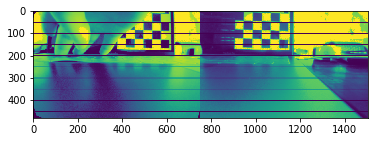

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

# 预处理
def preprocess(img1, img2):
    # 彩色图->灰度图
    im1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    im2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
 
    # 直方图均衡
    im1 = cv2.equalizeHist(im1)
    im2 = cv2.equalizeHist(im2)
 
    return im1, im2

# 消除畸变
def undistortion(image, camera_matrix, dist_coeff):
    undistortion_image = cv2.undistort(image, camera_matrix, dist_coeff)
 
    return undistortion_image
 
# 获取畸变校正和立体校正的映射变换矩阵、重投影矩阵
# @param：config是一个类，存储着双目标定的参数:config = stereoconfig.stereoCamera()

def getRectifyTransform(height, width, config):
    # 读取内参和外参
    left_K = config.cam_matrix_left
    right_K = config.cam_matrix_right
    left_distortion = config.distortion_l
    right_distortion = config.distortion_r
    R = config.R
    T = config.T
 
    # 计算校正变换
    height = int(height)
    width = int(width)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(left_K, left_distortion, right_K, right_distortion, (width, height), R, T, alpha=0)
 
    map1x, map1y = cv2.initUndistortRectifyMap(left_K, left_distortion, R1, P1, (width, height), cv2.CV_16SC2)
    map2x, map2y = cv2.initUndistortRectifyMap(right_K, right_distortion, R2, P2, (width, height), cv2.CV_16SC2)
    print(width,height)
 
    return map1x, map1y, map2x, map2y, Q
 
 
# 畸变校正和立体校正
def rectifyImage(image1, image2, map1x, map1y, map2x, map2y):
    rectifyed_img1 = cv2.remap(image1, map1x, map1y, cv2.INTER_LINEAR)
    rectifyed_img2 = cv2.remap(image2, map2x, map2y, cv2.INTER_LINEAR)
 
    return rectifyed_img1, rectifyed_img2
 
# 立体校正检验----画线
def draw_line(image1, image2):
    # 建立输出图像
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
 
    output = np.zeros((height, width), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
 
    for k in range(15):
        cv2.line(output, (0, 50 * (k + 1)), (2 * width, 50 * (k + 1)), (0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # 直线间隔：100
 
    return output

# 视差计算
def disparity_SGBM(left_image, right_image, down_scale=False):
    # SGBM匹配参数设置
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    param = {'minDisparity': 0,
             'numDisparities': 128,
             'blockSize': blockSize,
             'P1': 8 * img_channels * blockSize ** 2,
             'P2': 32 * img_channels * blockSize ** 2,
             'disp12MaxDiff': 12,
             'preFilterCap': 1,
             'uniquenessRatio': 5,
             'speckleWindowSize': 1,
             'speckleRange': 100,
             'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
             }
 
    # 构建SGBM对象
    sgbm = cv2.StereoSGBM_create(**param)
 
    # 计算视差图
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = sgbm.compute(left_image, right_image)
        disparity_right = sgbm.compute(right_image, left_image)
    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = size[0] / left_image_down.shape[1]
        disparity_left_half = sgbm.compute(left_image_down, right_image_down)
        disparity_right_half = sgbm.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA) 
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left *= factor 
        disparity_right *= factor
 
    return disparity_left, disparity_right

if __name__ == '__main__':
    imgL = cv2.imread("imagenew/left.jpg")
    imgR = cv2.imread("imagenew/right.jpg")
    imgL , imgR = preprocess(imgL ,imgR )
    
    
    height, width = imgL.shape[0:2]
    config = stereoCameral()    # 读取相机内参和外参
    
    # 去畸变
    imgL = undistortion(imgL ,config.cam_matrix_left , config.distortion_l )
    imgR = undistortion(imgR ,config.cam_matrix_right, config.distortion_r )
    
    # 去畸变和几何极线对齐
    map1x, map1y, map2x, map2y, Q = getRectifyTransform(height, width, config)
    iml_rectified, imr_rectified = rectifyImage(imgL, imgR, map1x, map1y, map2x, map2y)
    linepic = draw_line(iml_rectified , imr_rectified)
    plt.imshow(linepic)
    # 计算视差
    lookdispL,lookdispR = disparity_SGBM(iml_rectified  , imr_rectified )
    linepic2 = draw_line(lookdispL,lookdispR)
    # plt.imshow(lookdispL)
#     plt.imshow(linepic2)   
    points_3d = cv2.reprojectImageTo3D(lookdispL, Q)

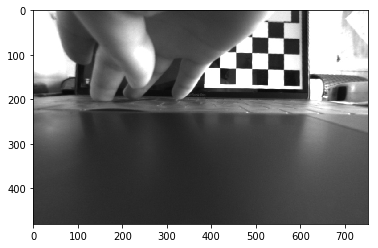

In [4]:
img1 = cv2.imread('imagenew/left.jpg')
plt.imshow(img1)

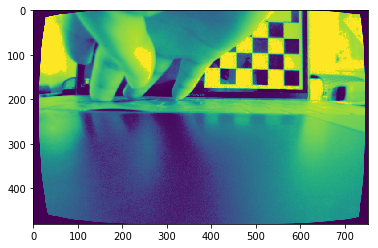

In [5]:
plt.imshow(imgL)

In [6]:
# 左右图的像素点坐标
# zuo y,x
n1 = np.array([[176 ,603],
              [111,111]])
# right
n2 = np.array([[180 ,401],
              [111,111]])
def tocam(K , tmp):
    fx = K[0][0]
    fy = K[1][1]
    cx = K[0][2]
    cy = K[1][2]
    u = tmp[0]
    v = tmp[1]
    x = (u-cx)/fx
    y = (v-cy)/fy
    tp = np.array([[x,y,1]])
    tp2 = np.transpose(tp)
    return tp2
tocam(config.cam_matrix_left , n1[0])*100

def lidaishu(tmp):
    f0 = tmp[0][0]
    f1 = tmp[1][0]
    f2 = tmp[2][0]
    out = np.array([[0,-f2,f1],
                   [f2 , 0, -f0],
                   [-f1 , f0 , 0]])
    return out
def zuixiaoercheng(A,B):
    tp1 = np.dot(np.transpose(A) , A)
    tp2 = np.linalg.inv(tp1)
    tp3 = np.dot(tp2,np.transpose(A))
    tp4 = np.dot(tp3 , -B)
    
#     tp1 = np.linalg.solve(A,-B)
    return tp4


In [96]:
print(config.T)

[[-1.20034808e+02]
 [-1.16533862e-02]
 [-6.78247449e-01]]


In [106]:
R = config.R.transpose()
t = np.dot(R,config.T)
for i in range(2):
    p1_uv = n1[i]
    p2_uv = n2[i]
    p1 = tocam(config.cam_matrix_left , p1_uv)
    p2 = tocam(config.cam_matrix_right , p2_uv)
    p1_ = lidaishu(p1)
    tp1 = np.dot(p1_ , R)
    A = np.dot(tp1 , p2)
    B = np.dot(p1_ , t)
#     s2 = zuixiaoercheng(A,B)
    s2 = -A[0]/B[0] 
    
    A = -p1
    B = s2*np.dot(R,p2) + t
    s1 = zuixiaoercheng(A,B)
    print(s1,s2)

[[28.00664824]] [-2.51700564]
[[55.10938671]] [-0.00858738]


In [102]:
R

array([[ 9.99969617e-01,  4.52289051e-04,  7.78208333e-03],
       [-4.50357979e-04,  9.99999867e-01, -2.49894020e-04],
       [-7.78219532e-03,  2.46381705e-04,  9.99969688e-01]])

In [87]:
config.T

array([[-1.20034808e+02],
       [-1.16533862e-02],
       [-6.78247449e-01]])

In [88]:
120*config.cam_matrix_left[0][0]/(200)

219.65177760340003

In [100]:
120*config.cam_matrix_left[1][1]/(2)

21936.490858701723